In [1]:
import sys
sys.path.append("..")

In [2]:
import gpfanova, analysis
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%matplotlib inline

In [4]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [112]:
x

array([[-1.        , -1.        ],
       [-1.        , -0.77777778],
       [-1.        , -0.55555556],
       [-1.        , -0.33333333],
       [-1.        , -0.11111111],
       [-1.        ,  0.11111111],
       [-1.        ,  0.33333333],
       [-1.        ,  0.55555556],
       [-1.        ,  0.77777778],
       [-1.        ,  1.        ],
       [-0.66666667, -1.        ],
       [-0.66666667, -0.77777778],
       [-0.66666667, -0.55555556],
       [-0.66666667, -0.33333333],
       [-0.66666667, -0.11111111],
       [-0.66666667,  0.11111111],
       [-0.66666667,  0.33333333],
       [-0.66666667,  0.55555556],
       [-0.66666667,  0.77777778],
       [-0.66666667,  1.        ],
       [-0.33333333, -1.        ],
       [-0.33333333, -0.77777778],
       [-0.33333333, -0.55555556],
       [-0.33333333, -0.33333333],
       [-0.33333333, -0.11111111],
       [-0.33333333,  0.11111111],
       [-0.33333333,  0.33333333],
       [-0.33333333,  0.55555556],
       [-0.33333333,

In [115]:
np.in1d(x[:,0],[-1,1]).shape,x.shape

((70,), (70, 2))

In [121]:
def oneEffectData(effects=3,n1=50,n2=5,r=2,nMissing=0,**kwargs):
    samples = r
    x1 = np.linspace(-1,1,n1)
    x2 = np.linspace(-1,1,n2)        
    
    x = cartesian([x1,x2])
    y = np.zeros((x.shape[0],effects*samples))

    e = []
    for i in range(effects):
        e += [i]*samples

    effect = np.array(e)[:,None]

    m = gpfanova.fanova.FANOVA(x,y,effect,helmert_covert=True,**kwargs)
    y,samples = m.samplePrior()
    
    missing = np.random.choice(range(n1),nMissing,replace=False)
    missingX = x1[missing]
    
    test = np.in1d(x[:,0],missingX)
    train = ~test
    
    ytrain = y.copy(); ytrain[test,:]=np.nan
    
    return x,y,effect,samples,ytrain

SamplerContainer:
y_sigma (Slice): y_sigma
f0 (Function): f0([-1. -1.]), f0([-1.         -0.77777778]), f0([-1.         -0.55555556]), ...
prior0_sigma (Slice): prior0_sigma
prior0_lengthscale0 (Slice): prior0_lengthscale0
prior0_lengthscale1 (Slice): prior0_lengthscale1

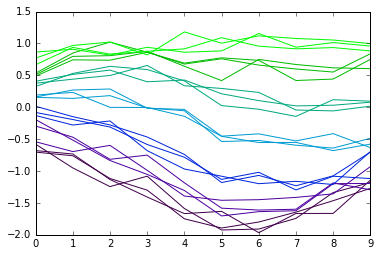

In [99]:
n1,n2 = 7,10

x,y,effect,samples,_,_ = oneEffectData(1,n1=n1,n2=n2,r=3,y_sigma=-2,helmertConvert=True)
m = gpfanova.mean.Mean(x,y)

for i in range(n2):
    plt.plot(y[i*n2:(i+1)*n2,:],c=plt.get_cmap("spectral")((i+.3)/(n2+.6)))

m

In [90]:
# x,y,effect,samples = analysis.data.oneEffectData(3,50,r=3,y_sigma=-2,helmertConvert=True)
# plt.plot(y)
# m = gpfanova.fanova.FANOVA(x,y,effect,helmertConvert=True)
# m

In [97]:
m.samplers

[y_sigma (Slice): y_sigma,
 f0 (Function): f0([-1. -1.]), f0([-1.         -0.77777778]), f0([-1.         -0.55555556]), ...,
 prior0_sigma (Slice): prior0_sigma,
 prior0_lengthscale0 (Slice): prior0_lengthscale0,
 prior0_lengthscale1 (Slice): prior0_lengthscale1]

In [98]:
m.design_matrix

array([[ 1.],
       [ 1.],
       [ 1.]])

In [100]:
# m.sample(20,1)
m.sample(10000,10)

In [101]:
m.parameter_history.shape

(1000, 74)

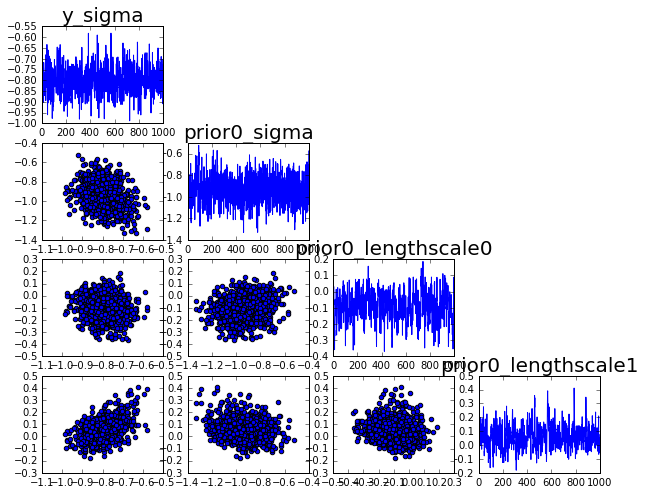

In [102]:
plt.figure(figsize=(10,8))
gpfanova.plot.plotHyperparameters(m,correlative=True)

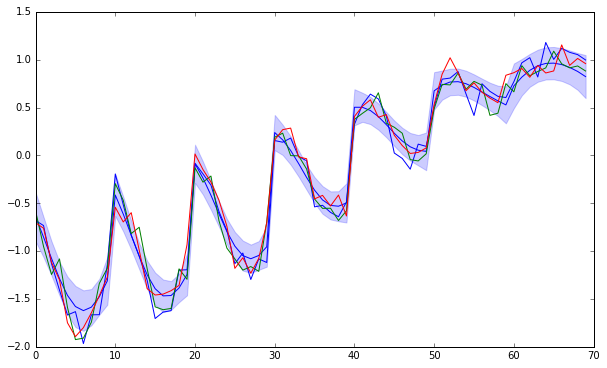

In [103]:
plt.figure(figsize=(10,6))
gpfanova.plot.plotFunctionSamples(m.functionSamples(0).values,burnin=20,intervalKwargs={'tol':1e-3})
plt.plot(y);

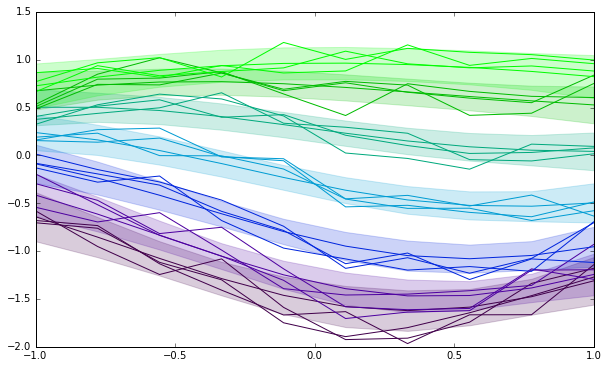

In [104]:
plt.figure(figsize=(10,6))

for i in range(n2):
    plt.plot(x[i*n2:(i+1)*n2,1],y[i*n2:(i+1)*n2,:],c=plt.get_cmap("spectral")((i+.3)/(n2+.6)))
    gpfanova.plot.plotFunctionSamples(m.functionSamples(0).values[:,i*n2:(i+1)*n2],x[i*n2:(i+1)*n2,1],
                                      burnin=20,intervalKwargs={'tol':1e-1},
                                      c=plt.get_cmap("spectral")((i+.3)/(n2+.6)))


## Missing data 

SamplerContainer:
y_sigma (Slice): y_sigma
f0 (Function): f0([-1. -1.]), f0([-1.         -0.81818182]), f0([-1.         -0.63636364]), ...
prior0_sigma (Slice): prior0_sigma
prior0_lengthscale0 (Slice): prior0_lengthscale0
prior0_lengthscale1 (Slice): prior0_lengthscale1

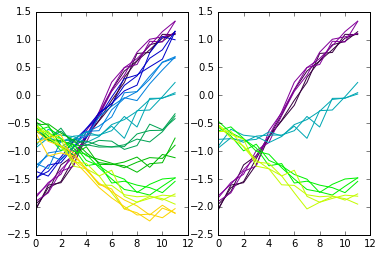

In [167]:
n1,n2 = 10,12

x,y,effect,samples,ytrain = oneEffectData(1,n1=n1,n2=n2,r=3,y_sigma=-2,helmertConvert=True,nMissing=5)
m = gpfanova.mean.Mean(x,ytrain)


for i in range(n2):
    plt.subplot(121)
    plt.plot(y[i*n2:(i+1)*n2,:],c=plt.get_cmap("spectral")((i+.3)/(n2+.6)))
    
    plt.subplot(122)
    plt.plot(ytrain[i*n2:(i+1)*n2,:],c=plt.get_cmap("spectral")((i+.3)/(n2+.6)))

m

In [168]:
m.sample(10000,10)

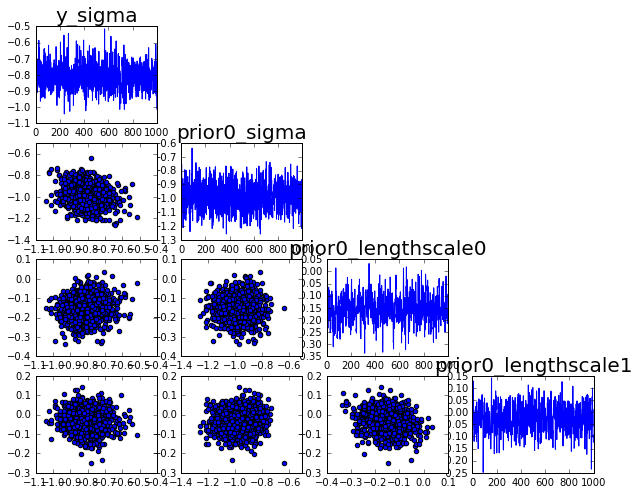

In [169]:
plt.figure(figsize=(10,8))
gpfanova.plot.plotHyperparameters(m,correlative=True)

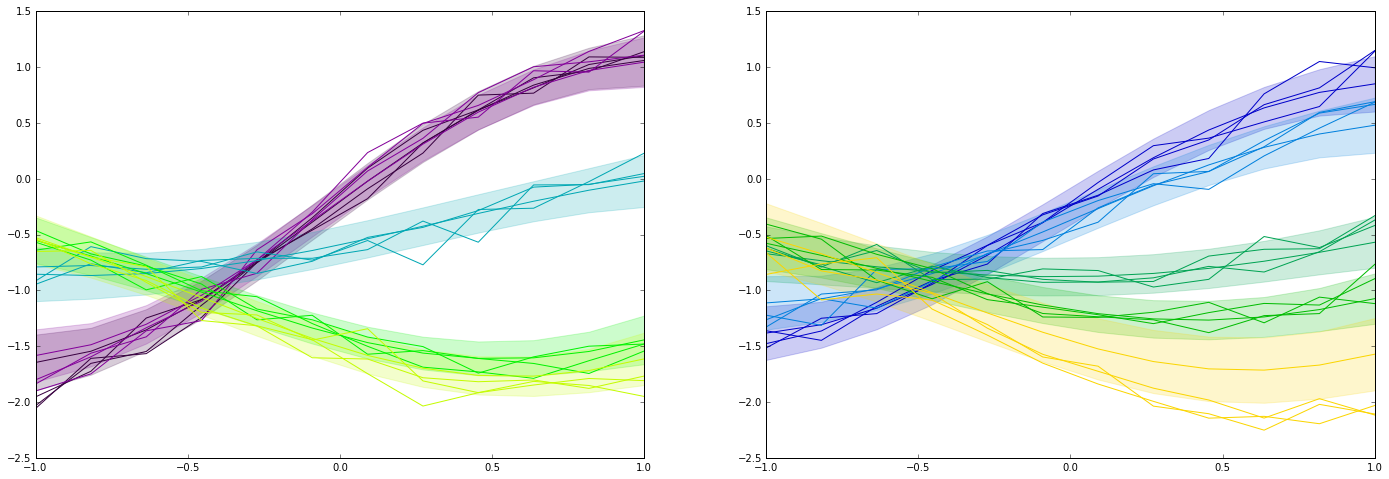

In [174]:
plt.figure(figsize=(24,8))

for i in range(n2):
    
    if np.isnan(ytrain[i*n2:(i+1)*n2,1]).any():
        plt.subplot(122)
    else:
        plt.subplot(121)
        
    plt.plot(x[i*n2:(i+1)*n2,1],y[i*n2:(i+1)*n2,:],c=plt.get_cmap("spectral")((i+.3)/(n2+.6)))
    gpfanova.plot.plotFunctionSamples(m.functionSamples(0).values[:,i*n2:(i+1)*n2],x[i*n2:(i+1)*n2,1],
                                      burnin=20,intervalKwargs={'tol':1e-1},
                                      c=plt.get_cmap("spectral")((i+.3)/(n2+.6)))


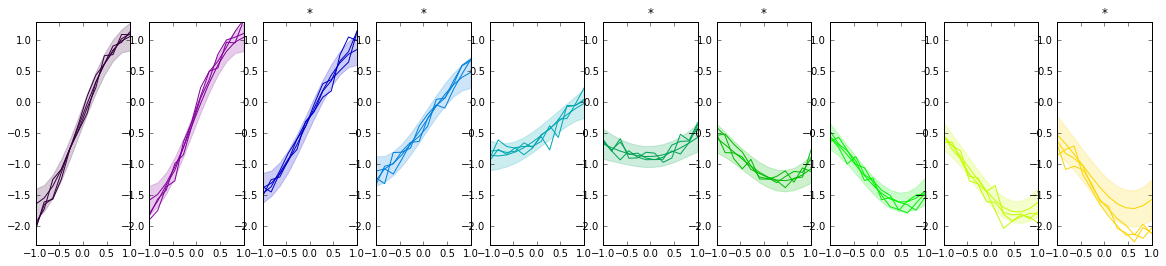

In [177]:
plt.figure(figsize=(20,4))

for i in range(n1):
    
    plt.subplot(1,n1,i+1)
    if np.isnan(ytrain[i*n2:(i+1)*n2,1]).any():
        plt.title("*")
        #plt.subplot(122)
    #else:
    #    plt.subplot(121)

    
        
    plt.plot(x[i*n2:(i+1)*n2,1],y[i*n2:(i+1)*n2,:],c=plt.get_cmap("spectral")((i+.3)/(n2+.6)))
    gpfanova.plot.plotFunctionSamples(m.functionSamples(0).values[:,i*n2:(i+1)*n2],x[i*n2:(i+1)*n2,1],
                                      burnin=20,intervalKwargs={'tol':1e-1},
                                      c=plt.get_cmap("spectral")((i+.3)/(n2+.6)))

    
    plt.ylim(-2.3,1.3)